In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import PredefinedSplit
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import os
import importlib

In [3]:
from model_pipeline import get_train_test, MissingValueTransformer, \
    CreateFeaturesTransformer, searcher_builder, data_formatted, \
    get_metrics, get_classification_metrics
from models import TorchRegressor

In [4]:
# Constants
RANDOM_STATE = 42
VALIDATION_PORTION = 0.2
FEATURES = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
            'PT08.S5(O3)', 'T', 'RH', 'AH']
TARGET = ['NMHC(GT)', 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
TARGET_ENOUGH=['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

In [5]:
# Global
train_dataset, test_dataset = get_train_test()
train_dataset_NMHC, test_dataset_NMHC = get_train_test(if_NMHC=True)

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7110 entries, 2004-03-10 18:00:00 to 2004-12-31 23:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NMHC(GT)       914 non-null    float64
 1   CO(GT)         5526 non-null   float64
 2   NO2(GT)        5543 non-null   float64
 3   NOx(GT)        5546 non-null   float64
 4   C6H6(GT)       6882 non-null   float64
 5   PT08.S1(CO)    6882 non-null   float64
 6   PT08.S2(NMHC)  6882 non-null   float64
 7   PT08.S3(NOx)   6882 non-null   float64
 8   PT08.S4(NO2)   6882 non-null   float64
 9   PT08.S5(O3)    6882 non-null   float64
 10  T              6882 non-null   float64
 11  RH             6882 non-null   float64
 12  AH             6882 non-null   float64
dtypes: float64(13)
memory usage: 777.7 KB


In [7]:
train_dataset_daily, test_dataset_daily = get_train_test('origin_data/air_quality_daily_mean.csv')

# Environment Preparation

In [5]:
# run this cell above

# Regression

In [19]:
short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    for target in TARGET:
        print(f"Processing target: {target}")
        X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
            train_dataset, test_dataset, target, params=features_config
        ) if target != 'NMHC(GT)' else data_formatted(
            train_dataset_NMHC, test_dataset_NMHC, target, params=features_config
        )

        model = TorchRegressor()

        hyperspace = {
            "model__lr": Real(1e-6, 1e-1, prior="log-uniform"),
            "model__hidden": Integer(128, 256),
            "model__epochs": Categorical([60]),
            "model__dropout": Real(0.1, 0.3)
        }

        nn_opt = searcher_builder(hyperspace, model, X_train.shape[0])
        nn_opt.fit(X_train, Y_train)
        pickle.dump(nn_opt, open(f'regression_searchers/reg_nn_{target}_{feature_set_name}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)
Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)


In [20]:
from sklearn.linear_model import LinearRegression
short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    for target in TARGET:
        print(f"Processing target: {target}")
        X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
            train_dataset, test_dataset, target, params=features_config
        ) if target != 'NMHC(GT)' else data_formatted(
            train_dataset_NMHC, test_dataset_NMHC, target, params=features_config
        )

        model = LinearRegression()

        hyperspace = {
            "model__fit_intercept": Categorical([True]),
        }

        nn_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
        nn_opt.fit(X_train, Y_train)
        pickle.dump(nn_opt, open(f'regression_searchers/reg_linear_{target}_{feature_set_name}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)
Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)


In [ ]:
from sklearn.linear_model import LinearRegression
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
for target in TARGET:

    print(f"Processing target: {target}")
    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target, params=long_features
    ) if target != 'NMHC(GT)' else data_formatted(
        train_dataset_NMHC, test_dataset_NMHC, target, params=long_features
    )

    model = LinearRegression()

    hyperspace = {
    "model__fit_intercept": Categorical([True]),
    }

    nn_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
    nn_opt.fit(X_train, Y_train)
    pickle.dump(nn_opt, open(f'regression_searchers/reg_linear_{target}_long.pkl', 'wb'))

Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)


In [10]:
train_dataset, test_dataset = get_train_test(if_NMHC=True)

In [ ]:
train_dataset, test_dataset = get_train_test(if_NMHC=True)
X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
    train_dataset, test_dataset, 'NMHC(GT)', params={'lags': [1,3,6,12,24], 'window_sizes': [3,6,12]}
)

model = LinearRegression()

hyperspace = {
    "model__fit_intercept": Categorical([True]),
}

linear_regression_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
linear_regression_opt.fit(X_train, Y_train)
pickle.dump(linear_regression_opt, open('regression_searchers/reg_linear_nmhc_short.pkl', 'wb'))

# Classification

In [10]:
from sklearn.svm import SVC

short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    target = 'CO(GT)'
    print(f"Processing target: {target}")
    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target, params=features_config, reg=False
    )

    for i,target_lag in enumerate([1,6,12,24]):
        model = SVC()

        hyperspace = {
        "model__C": Real(1e-3, 1e+3, prior="log-uniform"),
        "model__gamma": Real(1e-4, 1e-1, prior="log-uniform")
        }

        opt = searcher_builder(hyperspace, model, X_train.shape[0], reg=False)
        opt.fit(X_train, Y_train[:, i])
        pickle.dump(opt, open(f'classification_searchers/cls_svc_{target}_{feature_set_name}_{target_lag}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: CO(GT)


c:\LocalFile\9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000.0, 0.0001] before, using random point [6.618419316804846, 0.002985201914615943]
  warnings.warn(
c:\LocalFile\9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000.0, 0.0001] before, using random point [0.3296114109432843, 0.020114228787757323]
  warnings.warn(


Processing target: CO(GT)


In [7]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    target = 'CO(GT)'
    print(f"Processing target: {target}")
    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target, params=features_config, reg=False
    )

    for i,target_lag in enumerate([1,6,12,24]):
        model = XGBClassifier()

        hyperspace = {
            "model__n_estimators": Integer(50, 100),
            "model__learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
            "model__max_depth": Integer(3, 5),
            "model__min_child_weight": Integer(1, 10),
            "model__subsample": Real(0.5, 1.0),
            "model__colsample_bytree": Real(0.5, 1.0),
            "model__gamma": Real(1e-8, 1.0, prior="log-uniform"),
            "model__reg_alpha": Real(1e-8, 10.0, prior="log-uniform"),
            "model__reg_lambda": Real(1e-8, 10.0, prior="log-uniform"),
            "model__tree_method": Categorical(["hist"]),
            "model__device": Categorical(["cuda"]),
        }
        opt = searcher_builder(hyperspace, model, X_train.shape[0], reg=False)
        opt.fit(X_train, Y_train[:, i])
        pickle.dump(opt, open(f'classification_searchers/cls_gbc_{target}_{feature_set_name}_{target_lag}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: CO(GT)
Processing target: CO(GT)


# Evaluation

In [18]:
metrics_reg = {}

folder = "./regression_searchers"   # 你的文件夹

feature_sets = {
    'short': {'lags': [1,3,6,12,24], 'window_sizes': [3,6]},
    'long': {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
} 

def load_opt_from_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

for filename in os.listdir(folder):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder, filename)

    # ------- 1. 加载 opt -------
    opt = load_opt_from_pkl(file_path)

    # ------- 2. 从文件名提取目标列名 eg. CO(GT) -------
    # 文件名格式：
    #    reg_linear_CO(GT)_long.pkl
    #    reg_nn_NOx(GT)_short.pkl
    # => 我们取第三段（split("_")[2]）
    try:
        name_parts = filename.replace(".pkl", "").split("_")
        target_column = name_parts[2]     # eg. CO(GT)
        feature_set = name_parts[3]     # eg. long / short
    except:
        print(f"[WARN] 文件名格式无法解析：{filename}")
        continue

    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target_column, feature_sets[feature_set]
    ) if target_column != 'NMHC(GT)' else data_formatted(
        train_dataset_NMHC, test_dataset_NMHC, target_column, feature_sets[feature_set]
    )
    metrics = get_metrics(opt, 
                        X_test, Y_test, Y_baseline, scaler_Y, target_column)
    key = filename.replace(".pkl", "")
    metrics_reg[key] = metrics

C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:

In [19]:
metrics_cls = {}
folder = "./classification_searchers"   # 你的文件夹
feature_sets = {
    'short': {'lags': [1,3,6,12,24], 'window_sizes': [3,6]},
    'long': {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
} 

def load_opt_from_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

for filename in os.listdir(folder):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder, filename)

    # ------- 1. 加载 opt -------
    opt = load_opt_from_pkl(file_path)

    # ------- 2. 从文件名提取目标列名 eg. CO(GT) -------
    # 文件名格式：
    #    reg_linear_CO(GT)_long.pkl
    #    reg_nn_NOx(GT)_short.pkl
    # => 我们取第三段（split("_")[2]）
    try:
        name_parts = filename.replace(".pkl", "").split("_")
        target_column = 'CO(GT)'    # eg. CO(GT)
        feature_set = name_parts[3]     # eg. long / short
        lag = name_parts[4]     # eg. 1 / 6 / 12 /24
    except:
        print(f"[WARN] 文件名格式无法解析：{filename}")
        continue

    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target_column, feature_sets[feature_set], reg=False
    )
    Y_test = Y_test[:, ['1','6','12','24'].index(lag)]  # 只取对应lag的列
    Y_baseline = Y_baseline[:, ['1','6','12','24'].index(lag)]  # 只取对应lag的列
    metrics = get_classification_metrics(opt, 
                        X_test, Y_test, Y_baseline, target_column)
    key = filename.replace(".pkl", "")
    metrics_cls[key] = metrics

C:\Users\Shiki\AppData\Local\Temp\ipykernel_37820\50934526.py:10: UserWarning: [20:52:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  return pickle.load(f)
C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning:

In [21]:
import pandas as pd

def rmse_and_improvement_table(metrics_all):
    rows = []
    for model_name, m in metrics_all.items():
        rmse = m["rmse"]
        improvements = m["improvement_over_baseline_percentage"]
        var = m["column"]
        

        # improvements 是数组 → 每个 index 对应一行
        for i, imp in enumerate(improvements):
            rows.append({
                "target_column": var,
                "model": model_name,
                "time_horizon": f"_{['01','06','12','24'][i]}h",
                "rmse": rmse,
                "improvement_%": imp
            })

    df = pd.DataFrame(rows)
    df = df.sort_values(["target_column", "time_horizon","model"])
    return df

rmse_imp_df = rmse_and_improvement_table(metrics_reg)
rmse_imp_df.to_csv("./metrics/reg_accuracy_and_improvement_all_models.csv", index=False)


In [26]:
def rmse_and_improvement_table(metrics_cls):
    rows = []
    for model_name, m in metrics_cls.items():
        accuracy = m["accuracy"]
        improvements = m["improvement_over_baseline_percentage"]
        var = m["column"]

        # improvements 是数组 → 每个 index 对应一行
        rows.append({
            "target_column": var,
            "model": model_name,
            "time_horizon": f'{model_name.split("_")[4]:0>2}',  # 从模型名中提取时间范围
            "accuracy": accuracy,
            "improvement_%": improvements
        })

    df = pd.DataFrame(rows)
    df = df.sort_values(["target_column", "time_horizon","model"])
    return df

rmse_imp_df = rmse_and_improvement_table(metrics_cls)
rmse_imp_df.to_csv("./metrics/cls_accuracy_and_improvement_all_models.csv", index=False)

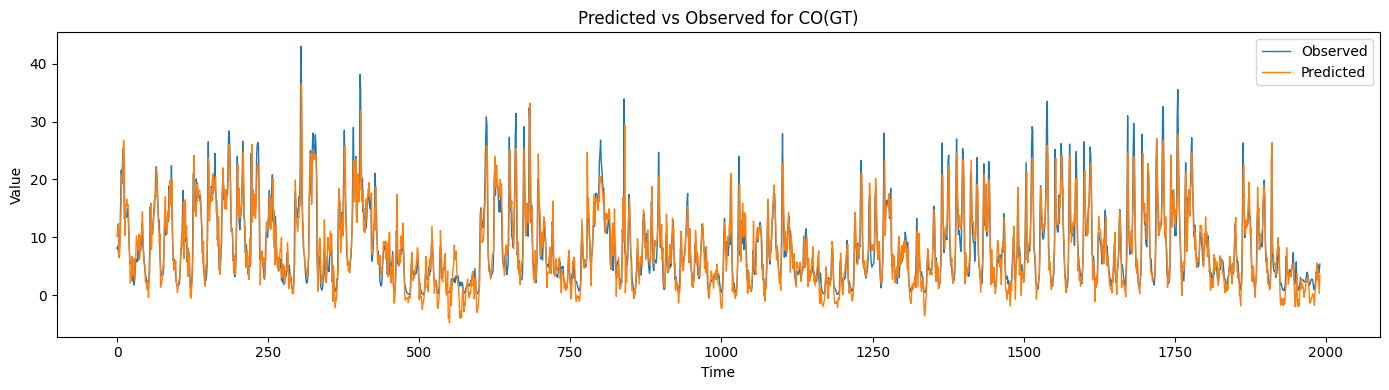

In [23]:
def plot_pred_vs_true(timestamps, y_true, y_pred, title="Predicted vs Observed"):
    plt.figure(figsize=(14, 4))
    plt.plot(timestamps, y_true, label="Observed", linewidth=1)
    plt.plot(timestamps, y_pred, label="Predicted", linewidth=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pred_vs_true(np.arange(len(metrics_reg['reg_linear_C6H6(GT)_long']['Y_test'][:,0])),
                  metrics_reg['reg_linear_C6H6(GT)_long']['Y_test'][:,0],metrics_reg['reg_linear_C6H6(GT)_long']['Y_pred'][:,0], title="Predicted vs Observed for CO(GT)")

# Anomaly Comparison

In [12]:
short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6], 'anomaly_detection_enabled': True}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24], 'anomaly_detection_enabled': True}
def train_models(features_config: dict, feature_set_name: str):
    for target in TARGET:
        print(f"Processing target: {target}")
        X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
            train_dataset, test_dataset, target, params=features_config
        ) if target != 'NMHC(GT)' else data_formatted(
            train_dataset_NMHC, test_dataset_NMHC, target, params=features_config
        )

        model = TorchRegressor()

        hyperspace = {
            "model__lr": Real(1e-6, 1e-1, prior="log-uniform"),
            "model__hidden": Integer(128, 256),
            "model__epochs": Categorical([60]),
            "model__dropout": Real(0.1, 0.3)
        }

        nn_opt = searcher_builder(hyperspace, model, X_train.shape[0])
        nn_opt.fit(X_train, Y_train)
        pickle.dump(nn_opt, open(f'regression_searchers/reg_nn_{target}_{feature_set_name}_anomaly.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: NMHC(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: CO(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: C6H6(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NOx(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NO2(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NMHC(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: CO(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: C6H6(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NOx(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NO2(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


In [14]:
from sklearn.linear_model import LinearRegression

short_features = {'lags': [1, 3, 6, 12, 24], 'window_sizes': [3, 6], 'anomaly_detection_enabled': True}
long_features = {'lags': [1, 3, 6, 12, 24], 'window_sizes': [12, 24], 'anomaly_detection_enabled': True}


def train_models(features_config: dict, feature_set_name: str):
    for target in TARGET:
        print(f"Processing target: {target}")
        X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
            train_dataset, test_dataset, target, params=features_config
        ) if target != 'NMHC(GT)' else data_formatted(
            train_dataset_NMHC, test_dataset_NMHC, target, params=features_config
        )

        model = LinearRegression()

        hyperspace = {
            "model__fit_intercept": Categorical([True]),
        }

        nn_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
        nn_opt.fit(X_train, Y_train)
        pickle.dump(nn_opt, open(f'regression_searchers/reg_linear_{target}_{feature_set_name}_anomaly.pkl', 'wb'))


train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: NMHC(GT)
Processing target: CO(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]
C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: C6H6(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NOx(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NO2(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]
C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NMHC(GT)
Processing target: CO(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: C6H6(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NOx(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: NO2(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


In [16]:
from sklearn.svm import SVC

short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6], 'anomaly_detection_enabled': True}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24], 'anomaly_detection_enabled': True}
def train_models(features_config: dict, feature_set_name: str):
    target = 'CO(GT)'
    print(f"Processing target: {target}")
    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target, params=features_config, reg=False
    )

    for i,target_lag in enumerate([1,6,12,24]):
        model = SVC()

        hyperspace = {
        "model__C": Real(1e-3, 1e+3, prior="log-uniform"),
        "model__gamma": Real(1e-4, 1e-1, prior="log-uniform")
        }

        opt = searcher_builder(hyperspace, model, X_train.shape[0], reg=False)
        opt.fit(X_train, Y_train[:, i])
        pickle.dump(opt, open(f'classification_searchers/cls_svc_{target}_{feature_set_name}_{target_lag}_anomaly.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: CO(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]


Processing target: CO(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]
C:\LocalFile\9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000.0, 0.0001] before, using random point [6.618419316804846, 0.002985201914615943]
  warnings.warn(
C:\LocalFile\9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000.0, 0.0001] before, using random point [3.363637156223258, 0.001925249360558798]
  warnings.warn(
C:\LocalFile\9417 Project\.venv\Lib\site-packages\skopt\

In [17]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6], 'anomaly_detection_enabled': True}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24], 'anomaly_detection_enabled': True}
def train_models(features_config: dict, feature_set_name: str):
    target = 'CO(GT)'
    print(f"Processing target: {target}")
    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target, params=features_config, reg=False
    )

    for i,target_lag in enumerate([1,6,12,24]):
        model = XGBClassifier()

        hyperspace = {
            "model__n_estimators": Integer(50, 100),
            "model__learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
            "model__max_depth": Integer(3, 5),
            "model__min_child_weight": Integer(1, 10),
            "model__subsample": Real(0.5, 1.0),
            "model__colsample_bytree": Real(0.5, 1.0),
            "model__gamma": Real(1e-8, 1.0, prior="log-uniform"),
            "model__reg_alpha": Real(1e-8, 10.0, prior="log-uniform"),
            "model__reg_lambda": Real(1e-8, 10.0, prior="log-uniform"),
            "model__tree_method": Categorical(["hist"]),
            "model__device": Categorical(["cuda"]),
        }
        opt = searcher_builder(hyperspace, model, X_train.shape[0], reg=False)
        opt.fit(X_train, Y_train[:, i])
        pickle.dump(opt, open(f'classification_searchers/cls_gbc_{target}_{feature_set_name}_{target_lag}_anomaly.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: CO(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]
C:\LocalFile\9417 Project\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [20:46:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will o

Processing target: CO(GT)


C:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\LocalFile\9417 Project\model_pipeline.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[mask], Y[mask]
